## Conditional Generative Adversarial Network

#### Mizra et. al 2018

In [14]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

# Torchvision datasets
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Types
from typing import Dict, List, Tuple
from torch import Tensor

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


# Set the random seed manually for reproducibility.
torch.manual_seed(1111)
np.random.seed(1111)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Currently running on: {}'.format(device))

Currently running on: cuda


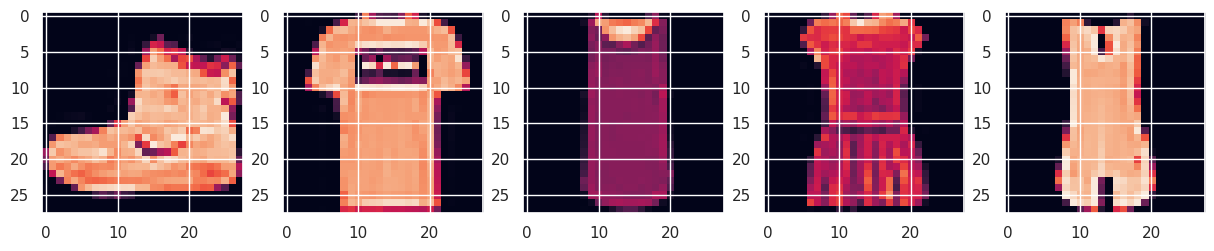

In [16]:
def show(img, ax=None):
    npimg = img.cpu().numpy()
    if ax is None:
      ax = plt
    ax.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')# Fashion MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.view(-1, 28*28)), # You can use any operation here
    # grey scale images
    transforms.Lambda(lambda x: x / 255)
])

dataset = datasets.FashionMNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)

# Visualize some images
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    show(dataset[i][0], ax[i])

### Models

- [x] Linear generator
- [x] Linear discriminator
- [x] Joint training
- [ ] Rework the discriminator

In [42]:
class Generator(nn.Module):
    def __init__(self, cfg: Dict) -> None:
        super().__init__()
        self.cfg = cfg
        self.input_dim = cfg['input_dim']
        self.output_dim = cfg['output_dim']
        self.hidden_dim = cfg['hidden_dim']
        
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(self.hidden_dim * 2, self.output_dim),
            nn.Tanh()
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.net(x)
    
    @property
    def device(self) -> torch.device:
        return next(self.parameters()).device

In [64]:
class Discriminator(nn.Module):
    def __init__(self, cfg: Dict) -> None:
        super().__init__()
        self.cfg = cfg
        self.input_dim = cfg['input_dim']
        self.output_dim = cfg['output_dim']
        
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512), # increase the output dimension for information gain
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid()
        )

    def forward(self, z: Tensor) -> Tensor:
        return self.net(z)

    @property
    def device(self) -> torch.device:
        return next(self.parameters()).device

In [65]:
generator_cfg = {
    'input_dim': 28 * 28,
    'output_dim': 28 * 28,
    'hidden_dim': 32
}

discriminator_cfg = {
    'input_dim': 28 * 28,
    'output_dim': 1
}

In [66]:
generator = Generator(generator_cfg).to(device)
discriminator = Discriminator(discriminator_cfg).to(device)

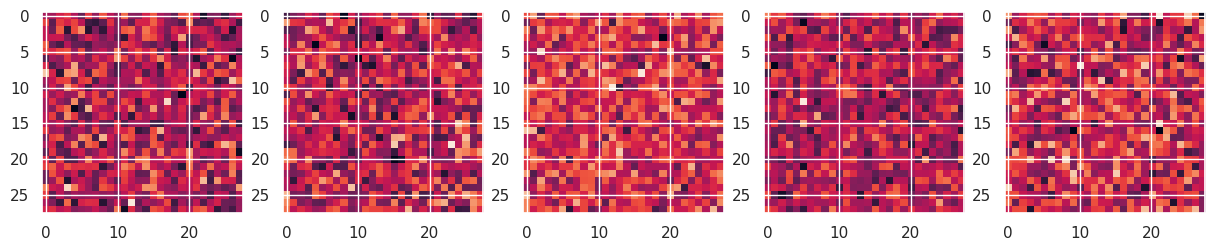

In [67]:
def noise_sample(n: int, dim: int) -> Tensor:
    return torch.randn(n, dim).to(device)

# Visualize some noise samples
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    show(noise_sample(1, 28*28).view(1, 28, 28), ax[i])

In [68]:
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)
loss = nn.BCELoss() # classification loss

In [72]:
def join_training(
    generator: nn.Module,
    discriminator: nn.Module,
    generator_optimizer: torch.optim.Optimizer,
    discriminator_optimizer: torch.optim.Optimizer,
    loss: nn.Module,
    dataset: datasets.FashionMNIST,
    epochs: int = 10,
    batch_size: int = 128,
    save_progress: bool = True
) -> None:
    
    # Create the dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Lists to keep track of progress
    generator_losses = []
    discriminator_losses = []

    # Number of batches
    num_batches = len(dataloader)
    
    generator.train()
    discriminator.train()
    
    for epoch in tqdm(range(epochs), total=epochs, desc='Training...'):
        for idx, data in enumerate(dataloader):
            # 1. Train Discriminator
            real_images, real_labels = data
            real_images = real_images.view(-1, 28*28)
            real_images = real_images.to(device)
            
            conditional_labels = real_labels.unsqueeze(1).repeat((1, 28 * 28))
            conditional_labels = conditional_labels.to(device)
            
            # Generate fake images
            noise = noise_sample(batch_size, 28*28)
            noise = torch.cat([noise, conditional_labels])

            fake_images = generator(noise)

            # Train on real images
            real_images = torch.cat([real_images, conditional_labels])
            real_preds = discriminator(real_images)
            real_targets = torch.ones_like(real_preds)
            real_loss = loss(real_preds, real_targets)

            # Train on fake images
            fake_images = torch.cat([fake_images, conditional_labels])
            fake_preds = discriminator(fake_images)
            fake_targets = torch.zeros_like(fake_preds)
            fake_loss = loss(fake_preds, fake_targets)

            # Backprop and optimize
            discriminator_loss = (real_loss + fake_loss) / 2
            discriminator_optimizer.zero_grad()
            discriminator_loss.backward()
            discriminator_optimizer.step()

            # 2. Train Generator
            # Generate fake images
            noise = noise_sample(batch_size, 28*28)
            noise = torch.cat([noise, conditional_labels])
            fake_images = generator(noise)

            # Train on fake images
            fake_images = torch.cat([fake_images, conditional_labels])
            preds = discriminator(fake_images)
            targets = torch.ones_like(preds)
            generator_loss = loss(preds, targets)

            # Backprop and optimize
            generator_optimizer.zero_grad()
            generator_loss.backward()
            generator_optimizer.step()

            if (idx + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Step [{idx+1}/{num_batches}], Generator Loss: {generator_loss:.4f}, Discriminator Loss: {discriminator_loss:.4f}")

            generator_losses.append(generator_loss.item())
            discriminator_losses.append(discriminator_loss.item())
        
    if not os.path.exists('./models/CAN/'):
        os.mkdir('./models/CAN/')
    
    # Prepare components for storage
    generator = generator.to('cpu')
    discriminator = discriminator.to('cpu')
    
    torch.save(generator.state_dict(), './models/CAN/generator.pth')
    torch.save(discriminator.state_dict(), './models/CAN/discriminator.pth')
        

In [73]:
join_training(
    generator=generator,
    discriminator=discriminator,
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    loss=loss,
    dataset=dataset,
    epochs=10,
    batch_size=128
)

Training...:   0%|                                                                                                                        | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Step [100/469], Generator Loss: 8.3264, Discriminator Loss: 14.7829
Epoch [1/10], Step [200/469], Generator Loss: 7.6186, Discriminator Loss: 15.3739
Epoch [1/10], Step [300/469], Generator Loss: 8.4224, Discriminator Loss: 15.0226
Epoch [1/10], Step [400/469], Generator Loss: 8.1759, Discriminator Loss: 15.0213


Training...:  10%|███████████▏                                                                                                    | 1/10 [00:06<01:00,  6.74s/it]

Epoch [2/10], Step [100/469], Generator Loss: 8.2960, Discriminator Loss: 15.8446
Epoch [2/10], Step [200/469], Generator Loss: 8.2608, Discriminator Loss: 14.4320
Epoch [2/10], Step [300/469], Generator Loss: 8.4548, Discriminator Loss: 15.4905
Epoch [2/10], Step [400/469], Generator Loss: 8.6422, Discriminator Loss: 14.9038


Training...:  20%|██████████████████████▍                                                                                         | 2/10 [00:13<00:53,  6.75s/it]

Epoch [3/10], Step [100/469], Generator Loss: 8.5103, Discriminator Loss: 15.0191
Epoch [3/10], Step [200/469], Generator Loss: 8.4586, Discriminator Loss: 15.7286
Epoch [3/10], Step [300/469], Generator Loss: 8.4291, Discriminator Loss: 15.1386
Epoch [3/10], Step [400/469], Generator Loss: 8.3361, Discriminator Loss: 15.4915


Training...:  30%|█████████████████████████████████▌                                                                              | 3/10 [00:20<00:47,  6.74s/it]

Epoch [4/10], Step [100/469], Generator Loss: 8.2222, Discriminator Loss: 15.9625
Epoch [4/10], Step [200/469], Generator Loss: 8.2479, Discriminator Loss: 14.7859
Epoch [4/10], Step [300/469], Generator Loss: 8.3922, Discriminator Loss: 15.3733
Epoch [4/10], Step [400/469], Generator Loss: 8.6570, Discriminator Loss: 15.4923


Training...:  40%|████████████████████████████████████████████▊                                                                   | 4/10 [00:27<00:40,  6.81s/it]

Epoch [5/10], Step [100/469], Generator Loss: 8.5347, Discriminator Loss: 15.6084
Epoch [5/10], Step [200/469], Generator Loss: 8.5307, Discriminator Loss: 14.9016
Epoch [5/10], Step [300/469], Generator Loss: 7.9832, Discriminator Loss: 14.9016
Epoch [5/10], Step [400/469], Generator Loss: 8.3031, Discriminator Loss: 15.6120


Training...:  50%|████████████████████████████████████████████████████████                                                        | 5/10 [00:33<00:33,  6.80s/it]

Epoch [6/10], Step [100/469], Generator Loss: 8.3900, Discriminator Loss: 14.9004
Epoch [6/10], Step [200/469], Generator Loss: 8.1463, Discriminator Loss: 15.0270
Epoch [6/10], Step [300/469], Generator Loss: 8.3362, Discriminator Loss: 15.2571
Epoch [6/10], Step [400/469], Generator Loss: 8.3109, Discriminator Loss: 14.0769


Training...:  60%|███████████████████████████████████████████████████████████████████▏                                            | 6/10 [00:40<00:27,  6.86s/it]

Epoch [7/10], Step [100/469], Generator Loss: 8.1623, Discriminator Loss: 14.7842
Epoch [7/10], Step [200/469], Generator Loss: 8.2295, Discriminator Loss: 15.1379
Epoch [7/10], Step [300/469], Generator Loss: 7.8072, Discriminator Loss: 15.8444
Epoch [7/10], Step [400/469], Generator Loss: 8.8583, Discriminator Loss: 15.2543


Training...:  70%|██████████████████████████████████████████████████████████████████████████████▍                                 | 7/10 [00:47<00:20,  6.86s/it]

Epoch [8/10], Step [100/469], Generator Loss: 8.1026, Discriminator Loss: 15.1378
Epoch [8/10], Step [200/469], Generator Loss: 8.5798, Discriminator Loss: 14.7878
Epoch [8/10], Step [300/469], Generator Loss: 8.2873, Discriminator Loss: 15.0204
Epoch [8/10], Step [400/469], Generator Loss: 8.8771, Discriminator Loss: 15.5000


Training...:  80%|█████████████████████████████████████████████████████████████████████████████████████████▌                      | 8/10 [00:54<00:13,  6.90s/it]

Epoch [9/10], Step [100/469], Generator Loss: 8.4827, Discriminator Loss: 15.7269
Epoch [9/10], Step [200/469], Generator Loss: 8.7052, Discriminator Loss: 15.3720
Epoch [9/10], Step [300/469], Generator Loss: 8.9262, Discriminator Loss: 15.3741
Epoch [9/10], Step [400/469], Generator Loss: 8.4797, Discriminator Loss: 14.6674


Training...:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 9/10 [01:01<00:06,  6.88s/it]

Epoch [10/10], Step [100/469], Generator Loss: 8.5171, Discriminator Loss: 14.4323
Epoch [10/10], Step [200/469], Generator Loss: 8.5127, Discriminator Loss: 15.4916
Epoch [10/10], Step [300/469], Generator Loss: 8.9257, Discriminator Loss: 15.3747
Epoch [10/10], Step [400/469], Generator Loss: 8.2687, Discriminator Loss: 14.9093


Training...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:08<00:00,  6.84s/it]


### Qualitative performance measure

In [74]:
# Load models from persistent storage
generator = Generator(generator_cfg)
discriminator = Discriminator(discriminator_cfg)

generator.load_state_dict(torch.load('./models/CAN/generator.pth'))
discriminator.load_state_dict(torch.load('./models/CAN/discriminator.pth'))

generator = generator.to(device)
discriminator = discriminator.to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


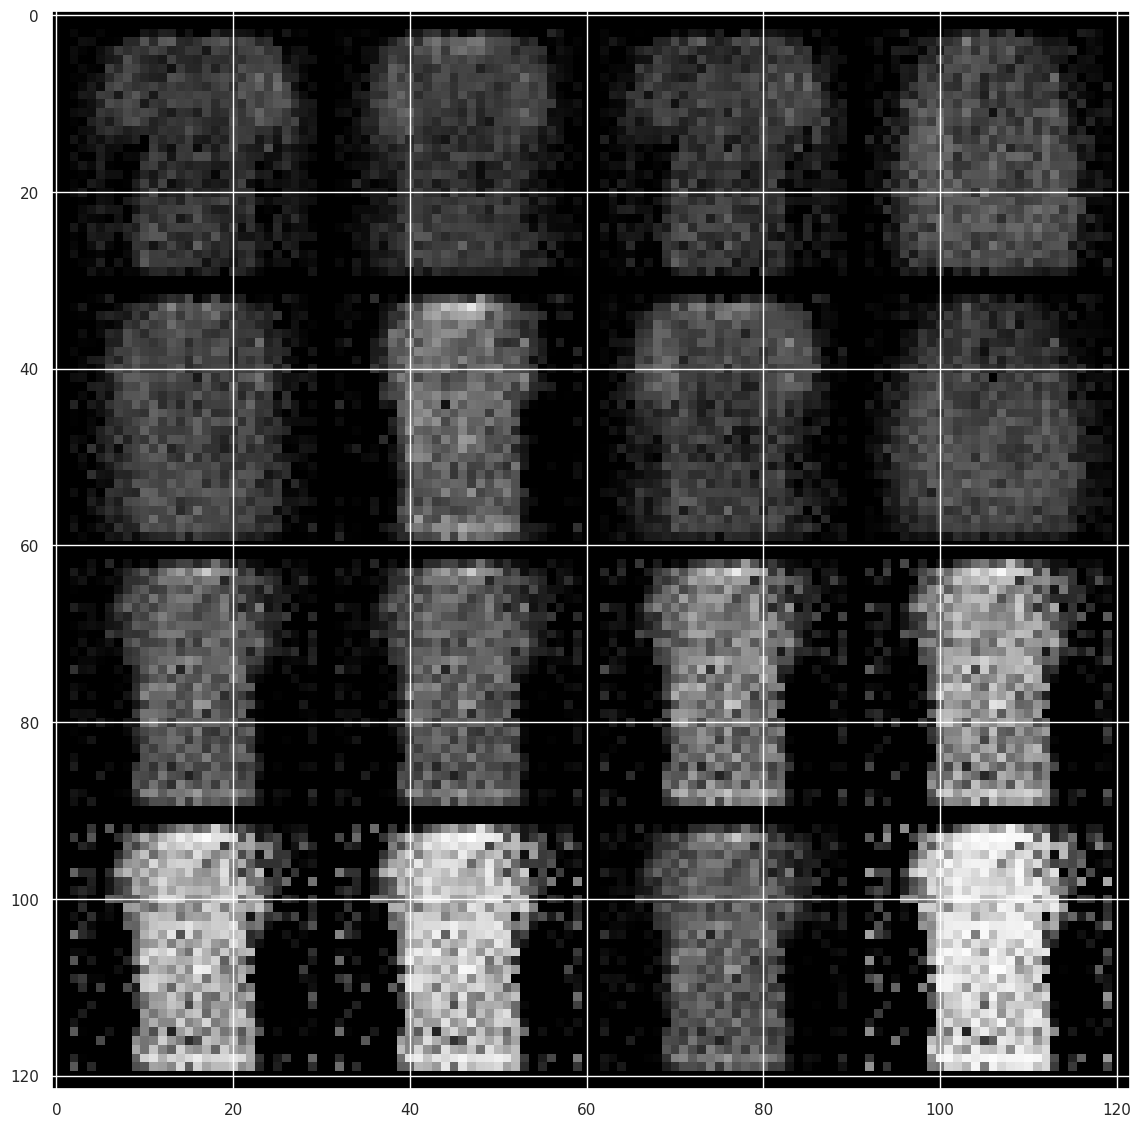

In [89]:
# Generate fake images
noise = noise_sample(8, 28 * 28)
conditional_labels = torch.Tensor([2, 2, 3, 4, 5, 6, 2, 8])
conditional_labels = conditional_labels.unsqueeze(1).repeat((1, 28 * 28)).to(device)

noise = torch.cat([noise, conditional_labels])
fake_images = generator(noise)

# Plot the gnerated samples
img2 = make_grid(fake_images.view(16, 1, 28, 28), nrow=4)
fig, ax = plt.subplots(figsize=(14, 14))
show(img2, ax)